In [15]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors


import tqdm
from skimage.feature import hog
from skimage import data, exposure

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn import tree

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from tools import *

In [16]:
def getConfusionMatrix(y_true, y_pred, model):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

    plt.show()
    return cm
    

In [2]:
path = "images-photographes"

In [3]:
inames, ilabels, class_names = load_dataset(path)

In [4]:
inames, ilabels, class_names

(['daido-moriyama\\16_daido_moriyama_24.jpg',
  'daido-moriyama\\16_daido_moriyama_25.jpg',
  'daido-moriyama\\16_daido_moriyama_26.jpg',
  'daido-moriyama\\16_daido_moriyama_27.jpg',
  'daido-moriyama\\21_moriyama_mep_050.jpg',
  'daido-moriyama\\21_moriyama_mep_051.jpg',
  'daido-moriyama\\21_moriyama_mep_059.jpg',
  'daido-moriyama\\21_moriyama_mep_063.jpg',
  'daido-moriyama\\21_moriyama_mep_064.jpg',
  'daido-moriyama\\21_moriyama_mep_065.jpg',
  'daido-moriyama\\21_moriyama_mep_066.jpg',
  'daido-moriyama\\21_moriyama_mep_068.jpg',
  'daido-moriyama\\21_moriyama_mep_073.jpg',
  'daido-moriyama\\21_moriyama_mep_075.jpg',
  'daido-moriyama\\21_moriyama_mep_077.jpg',
  'daido-moriyama\\21_moriyama_mep_078.jpg',
  'daido-moriyama\\21_moriyama_mep_079.jpg',
  'daido-moriyama\\21_moriyama_mep_080.jpg',
  'daido-moriyama\\21_moriyama_mep_081.jpg',
  'daido-moriyama\\21_moriyama_mep_082.jpg',
  'daido-moriyama\\21_moriyama_mep_083.jpg',
  'daido-moriyama\\21_moriyama_mep_085.jpg',
  'dai

In [5]:
laplacians = ComputeLaplacians(inames)

100%|████████████████████████████████████████████████████████████████████████████████| 280/280 [00:16<00:00, 17.36it/s]


In [7]:
laplacians = np.array(laplacians)

In [8]:
np.save('DATA_LAPLACIANS.npy', laplacians)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(laplacians ,ilabels,
                                                    test_size=0.2,stratify=ilabels)

In [18]:
print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

Training data and target sizes: 
(224, 1048576), (224,)
Test data and target sizes: 
(56, 1048576), (56,)


In [20]:
test_accuracy = []
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled_Test = scaler.transform(X_test)
classifier = KNeighborsClassifier(n_neighbors=1,algorithm='brute')
classifier.fit(X_train, y_train)
#test_accuracy = classifier.score(scaler.transform(X_scaled_Test), y_test)
y_hat_test = classifier.predict(X_test)
acc_KNN = accuracy_score(y_true=y_test, y_pred=y_hat_test)
print(acc_KNN)

0.16071428571428573


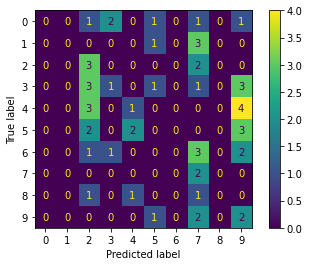

In [21]:
cm = getConfusionMatrix(y_test, y_hat_test, classifier)

In [22]:
model_one = SVC(C=40, kernel='linear', max_iter=10000, probability=True)
# Fit on sub-train set
# TODO
model_one.fit(X_train, y_train)
# Evaluate on val set
# TODO
y_hat_test = model_one.predict(X_test)
acc1 = accuracy_score(y_true=y_test, y_pred=y_hat_test)
print(f'--> accuracy = {acc1}')

--> accuracy = 0.23214285714285715


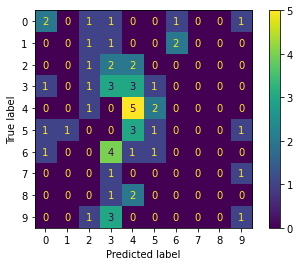

In [23]:
cm = getConfusionMatrix(y_test, y_hat_test, model_one)

In [24]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
acc3 = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",acc3)

Accuracy: 0.26785714285714285


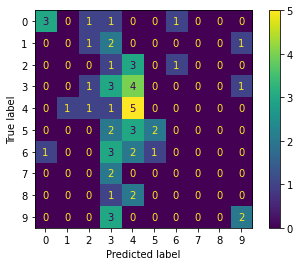

In [25]:
cm = getConfusionMatrix(y_test, y_pred, clf)

In [ ]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=100, learning_rate = 0.01)
# Train Adaboost Classifer
model4 = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_hat = model4.predict(X_test)

acc4 = model4.score(X_test, y_test)
print(f'--> accuracy = {acc4}')

In [ ]:
cm = getConfusionMatrix(y_test, y_hat, model4)

In [28]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model_BC = BaggingClassifier(tree.DecisionTreeClassifier(random_state=2))
model_BC.fit(X_train, y_train)
y_hat = model_BC.predict(X_test)

acc5 = model_BC.score(X_test,y_test)
print(f'--> accuracy = {acc5}')

--> accuracy = 0.25


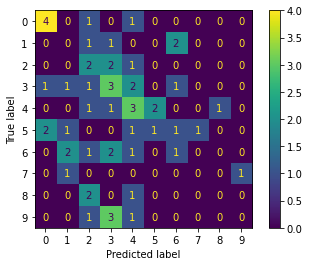

In [29]:
cm = getConfusionMatrix(y_test, y_hat, model_BC)

In [ ]:
ensemble = [('svc', model_one), ('knn', classifier),('rf', clf),('ada', model4), ('Bagging', model_BC)]

eclf3 = VotingClassifier(ensemble)

eclf3 = VotingClassifier(estimators=[
      ('svc', model_one), ('knn', classifier),('rf', clf),('ada', model4), ('Bagging', model_BC)],
       voting='soft',
       flatten_transform=True, weights=[1,1,1,1,1])

#results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)

eclf3 = eclf3.fit(X_train, y_train)
y_pred = eclf3.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f'--> accuracy = {acc}')

In [ ]:
cm = getConfusionMatrix(y_test, y_pred, eclf3)